In [1]:
import sys
sys.path.insert(0, "./../../scripts")

In [2]:
import pickle
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

import sim_util as su
import ricciardi as ric
import integrate as integ
import dmft

# Plot the Model Schematic from Fig 1a

In [3]:
with open("./../../model_data/schematic_prms.pkl", "rb") as handle:
    res_dict = pickle.load(handle)[0]
    
prms = res_dict["prms"]
eX = res_dict["best_monk_eX"]
bX = res_dict['best_monk_bX']
aXs = res_dict['best_monk_aXs']

ri = ric.Ricciardi()
ri.set_up_nonlinearity("./../../model_data/phi_int")
ri.set_up_nonlinearity_tensor()

NtE = 50
Nt = NtE*ri.tE
dt = ri.tI/5
T = torch.linspace(0,8*Nt,round(8*Nt/dt)+1)
mask_time = T>(4*Nt)
T_mask = T.cpu().numpy()[mask_time]

N = 10000
Nori = 20
NE = 4*(N//Nori)//5
NI = 1*(N//Nori)//5

this_prms = prms.copy()
this_prms["Nori"] = Nori
this_prms["NE"] = NE
this_prms["NI"] = NI

Loading previously saved nonlinearity
Using mps


In [4]:
start = time.process_time()

net,M,H,B,LAS,eps = su.gen_ring_disorder_tensor(0,this_prms,eX)

Inp = (bX*B+aXs[-1]*H)*eps

print("Generating disorder took ",time.process_time() - start," s")
print("")

# start = time.process_time()

# sol,_ = integ.sim_dyn_tensor(ri,T,0.0,M,Inp,LAS,net.C_conds[0],mult_tau=True)
# rates = torch.mean(sol[:,mask_time],axis=1).cpu().numpy()

# np.save("./../../model_data/best_fit_vis_rates",rates)

# print("Integrating network took ",time.process_time() - start," s")
# print("")

rates = np.load("./../../model_data/best_fit_vis_rates.npy")

Using mps
Generating disorder took  2.5558739999999998  s



In [5]:
radEring = 25
radIring = 22
radEpop = 2
radIpop = 1

Nperori = N//Nori
pts = np.zeros((N,2))
pops = np.zeros(N).astype(int)
colors = [None,]*N

rng = np.random.default_rng(0)
for i in range(net.N):
    locidx = i//Nperori
    popidx = 0 if (i%Nperori) < net.NC[0] else 1
    pops[i] = popidx
    colors[i] = ["r","b"][popidx]
    
    r = np.sqrt(rng.random())
    tht = rng.random()*2*np.pi
    
    if popidx==0:
        pts[i,0] = radEring*np.cos(2*np.pi*(locidx-0.12)/Nori) + radEpop*r*np.cos(tht)
        pts[i,1] = radEring*np.sin(2*np.pi*(locidx-0.12)/Nori) + radEpop*r*np.sin(tht)
    else:
        pts[i,0] = radIring*np.cos(2*np.pi*(locidx+0.12)/Nori) + radIpop*r*np.cos(tht)
        pts[i,1] = radIring*np.sin(2*np.pi*(locidx+0.12)/Nori) + radIpop*r*np.sin(tht)

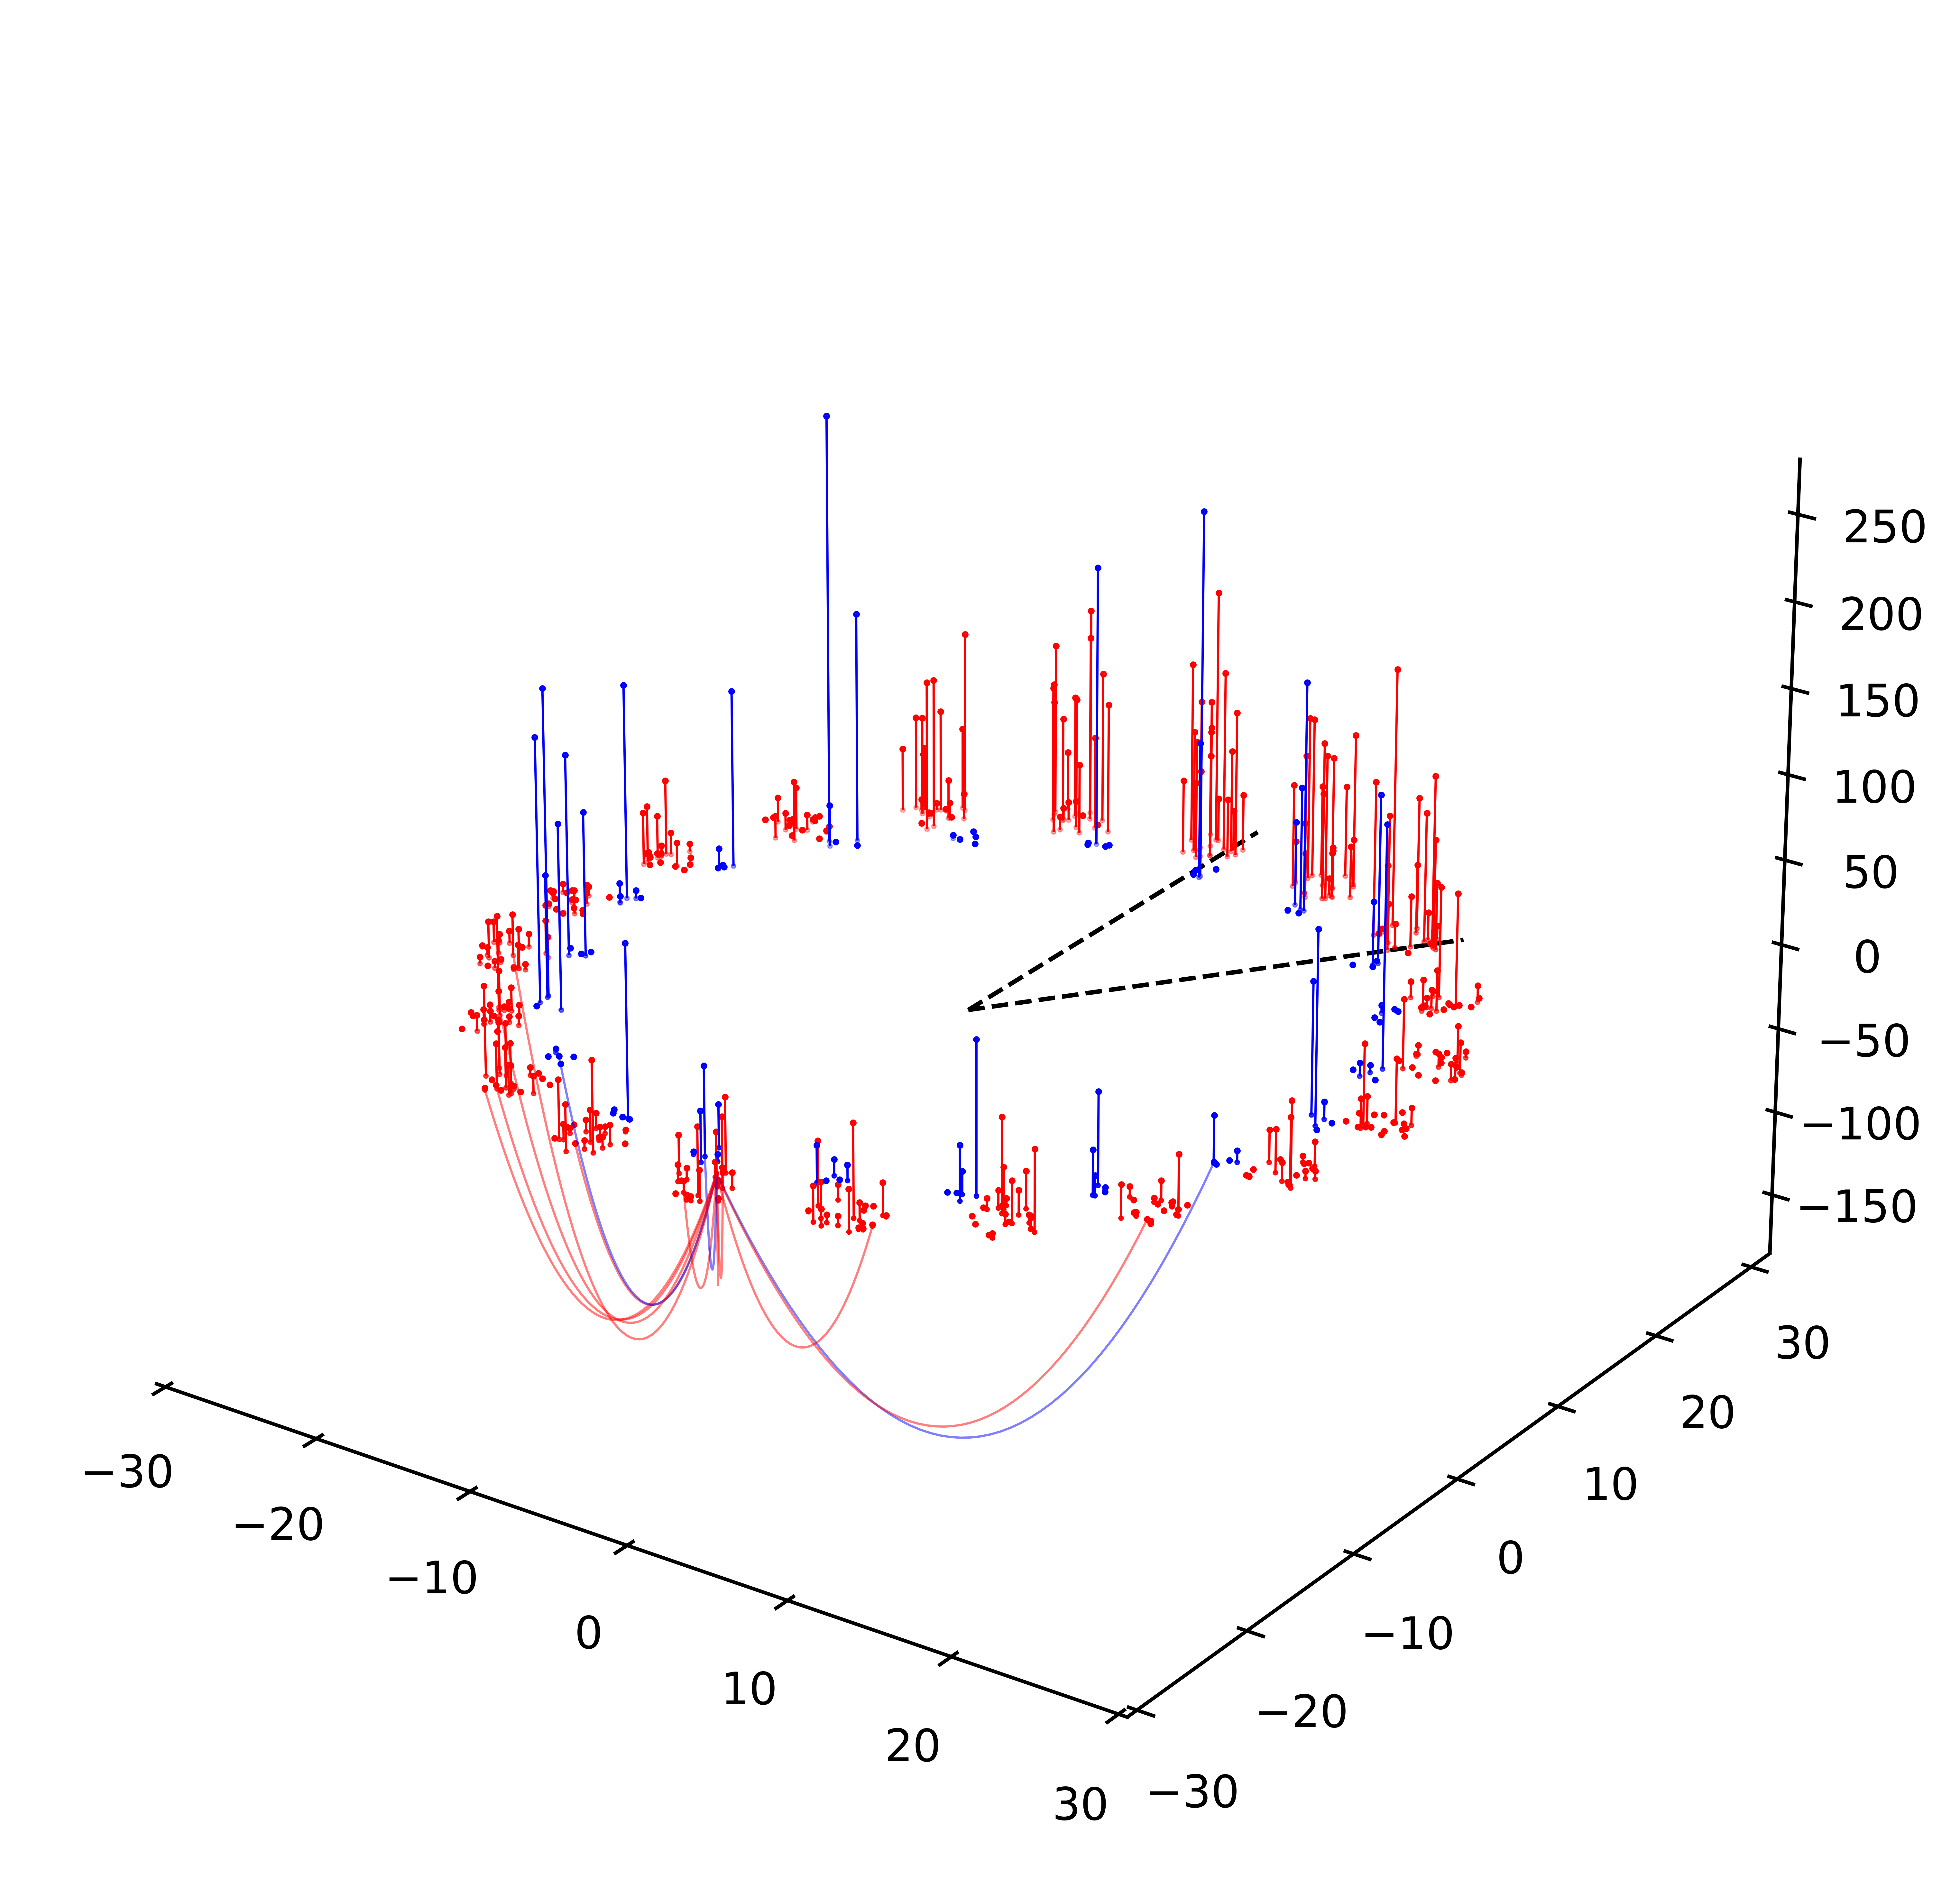

In [6]:
fig,ax = plt.subplots(1,1,figsize=(6,6),dpi=1000,subplot_kw=dict(projection="3d",computed_zorder=False))

def xy_path(pti,ptf,npts):
    ri = np.sqrt(np.sum(pti**2))
    rf = np.sqrt(np.sum(ptf**2))
    thti = np.arctan2(pti[0],pti[1])
    thtf = np.arctan2(ptf[0],ptf[1])
    return np.linspace(ri,rf,npts)*np.cos(np.linspace(thti,thtf,npts)),\
                np.linspace(ri,rf,npts)*np.sin(np.linspace(thti,thtf,npts))

skip = 20
s = 1
npts = 50
ax.scatter(pts[::skip,1],pts[::skip,0],np.zeros(net.N//skip),s=s,lw=s/4,c=colors[::skip])
ax.plot([0,0],[0,radEring+radEpop*1.5],[0,0],"k--",lw=s,zorder=0)
ax.plot([0,(radEring+radEpop*1.5)*np.sin(2*2*np.pi/net.Nori)],
        [0,(radEring+radEpop*1.5)*np.cos(2*2*np.pi/net.Nori)],[0,0],"k--",lw=s,zorder=0)
for i in range(0,N,2*skip):
    h = abs(((i-N//2)//Nperori)/Nori)
    if h < 0.5: h = 1-h
    h = 2*(h-0.5)
    h = np.sqrt(1 - 0.8*h)
    reps = [5]#1,2,4
    for j in reps:
        if np.abs(net.M[i,N//2+j*skip]) > 1e-12:
                ax.plot(np.linspace(pts[N//2,1],pts[i,1],npts),
                        np.linspace(pts[N//2,0],pts[i,0],npts),
                        -300*(h**2-np.linspace(-h,h,npts)**2),colors[i],lw=s/2,alpha=0.5)
                # ax.plot(*xy_path(pts[N//2],pts[i],npts),
                #         -300*(h**2-np.linspace(-h,h,npts)**2),colors[i],lw=s/2,alpha=0.5)
Emarkerline,Estemline,Ebaseline = ax.stem(pts[net.C_all[0],1][::skip],pts[net.C_all[0],0][::skip],
                                            rates[net.C_all[0]][::skip])
Imarkerline,Istemline,Ibaseline = ax.stem(pts[net.C_all[1],1][::skip],pts[net.C_all[1],0][::skip],
                                            rates[net.C_all[1]][::skip])
plt.setp(Ebaseline,linewidth = 0)
plt.setp(Ibaseline,linewidth = 0)
plt.setp(Estemline,linewidth = s/2,color="r",zorder=1)
plt.setp(Istemline,linewidth = s/2,color="b",zorder=2)
plt.setp(Emarkerline,markersize = s/2,color="r",zorder=1)
plt.setp(Imarkerline,markersize = s/2,color="b",zorder=2)

# make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]["color"] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]["color"] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]["color"] =  (1,1,1,0)

ax.view_init(elev=25,azim=-55)

fig.tight_layout()
fig.savefig("./fig_1a.pdf")

# Plot the Rate Moment Schematic from Fig 1b

In [7]:
rb = np.array([15.133126,15.398534])
rp = np.array([78.02721,55.94795])
sr = np.array([16.641127,25.300125])

Crb = np.array([387.83896,801.8631])
Crp = np.array([8555.255,8954.791])
sCr = np.array([14.703152,23.641306])

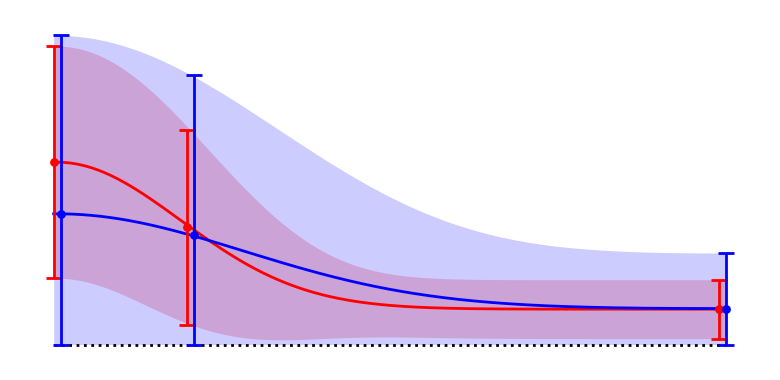

In [8]:
oris = np.linspace(-0.5,90.5,361)
suboris = np.array([0,18,90])
base_r = 0

def gauss(x,b,p,s2):
    return b + (p-b)*dmft.basesubwrapnorm(x,np.sqrt(s2))

size = 2
fig,ax = plt.subplots(1,1,figsize=(2*size,1*size),dpi=200)

rE = gauss(oris,rb[0],rp[0],sr[0]**2)
rI = gauss(oris,rb[1],rp[1],sr[1]**2)
sigrE = np.sqrt(gauss(oris,Crb[0],Crp[0],sCr[0]**2)-\
    gauss(oris,rb[0],rp[0],sr[0]**2)**2)
sigrI = np.sqrt(gauss(oris,Crb[1],Crp[1],sCr[1]**2)-\
    gauss(oris,rb[1],rp[1],sr[1]**2)**2)
subrE = gauss(suboris,rb[0],rp[0],sr[0]**2)
subrI = gauss(suboris,rb[1],rp[1],sr[1]**2)
subsigrE = np.sqrt(gauss(suboris,Crb[0],Crp[0],sCr[0]**2)-\
    gauss(suboris,rb[0],rp[0],sr[0]**2)**2)
subsigrI = np.sqrt(gauss(suboris,Crb[1],Crp[1],sCr[1]**2)-\
    gauss(suboris,rb[1],rp[1],sr[1]**2)**2)
ax.plot(oris*2*np.pi/180,base_r+rE,"r",lw=1)
ax.plot(oris*2*np.pi/180,base_r+rI,"b",lw=1)
ax.fill_between(oris*2*np.pi/180,base_r+rE+sigrE,base_r+np.fmax(0,rE-sigrE),color="r",lw=0,alpha=0.2)
ax.fill_between(oris*2*np.pi/180,base_r+rI+sigrI,base_r+np.fmax(0,rI-sigrI),color="b",lw=0,alpha=0.2)
ax.plot(oris*2*np.pi/180,base_r*np.ones_like(oris),c="k",ls=":",lw=1)
ax.scatter((suboris-0.5)*2*np.pi/180,base_r+subrE,s=10,c="r",lw=0,zorder=4)
ax.scatter((suboris+0.5)*2*np.pi/180,base_r+subrI,s=10,c="b",lw=0,zorder=4)
ax.errorbar((suboris-0.5)*2*np.pi/180,base_r+subrE,[np.fmin(subrE,subsigrE),subsigrE],
    c="r",ls="none",capsize=3,lw=1,capthick=1,zorder=4,dash_capstyle="projecting")
ax.errorbar((suboris+0.5)*2*np.pi/180,base_r+subrI,[np.fmin(subrI,subsigrI),subsigrI],
    c="b",ls="none",capsize=3,lw=1,capthick=1,zorder=4,dash_capstyle="projecting")

ax.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
ax.axis("off")

fig.tight_layout()
fig.savefig("./fig_1b.pdf")